# Summary: 

This notebook is for analyzing experiments for checking the quality of utility model learned using different methods (st, pca) on different sets of axes (for PCA) and on data with varying levels of low-rank-ness. The problems have 1-dimensional input, 20-dimensional output. We look at linear utility functions, where the utility coefficient has norm 1, and we vary $\alpha$, the norm of the projection of the utility coefficient in the true outcome subspace. In particular, we look at the three kinds of reduced models:
- "learned": projecting to the PCA learned subspace (variance threshold 0.9)
- "true": projecting to the true outcome subspace
- "oracle": projecting to the 1-dim subspace spanned by the utility coefficient

We check the accuracy of the utility model (predicting preferences on a separate test set) that is fit on either (1) pairwise comparison data or (2) true utility values (both from the same dataset). We plot the utility model accuracy for different methods over different values of $\alpha$. 

Empirical results show that
- Fitting utility models on true utility values results in higher test accuracy than fitting on pairwise comparisons
- With enough data, ST can learn the utility model well; it seems that the PCA-type methods have the potential of surpassing ST only when there isn't sufficient training data
- Knowing the true outcome subspace doens't necessarily help you when $\alpha$ is small, because you throw away information about how the utility varies with the residual outcome space; only when $\alpha$ is large and there's not sufficient data for the ST model to learn well does it seem that PCA has an edge.

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# output_path = '/home/yz685/low_rank_BOPE/experiments/util_fit_5_20/'
# rank_vals = [1,2,4,6,8]

output_path = '/home/yz685/low_rank_BOPE/experiments/util_fit_1_20/'
rank_vals = [1,2,4]

In [3]:
# data structure for extracting the results
# degrees of freedom: rank, method, type of axes, alpha
# want to plot: acc vs alpha for different types of axes

In [4]:
results = defaultdict(dict)

In [5]:

for rank in rank_vals:
    for method in ['pca', 'st']:
        dd = []
        for trial in range(1, 11):
            try:
                d = torch.load(output_path + f'rank_{rank}_linear_{method}_acc_trial={trial}.pt')
                # len(d) = number of reps; len(d[0]) = number of alpha values
                dd.append(pd.DataFrame.from_dict(d, orient = 'index'))
            except FileNotFoundError:
                continue 
            
        dd = pd.concat(dd)
        dd_agg = dd.groupby(['alpha']).aggregate(['mean', 'sem'])
        results[rank][method] = dd_agg


In [6]:
for rank in rank_vals:
    print(f"true rank {rank}, PCA learned latent dim {results[rank]['pca'][('learned_latent_dim', 'mean')].values[0]}")

true rank 1, PCA learned latent dim 16.0
true rank 2, PCA learned latent dim 14.0
true rank 4, PCA learned latent dim 9.0


In [7]:
def plot_helper(rank):

    alphas = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    fig, axs = plt.subplots(1,2, figsize = (12,4))

    for col in ['pca_learned_rel', 'pca_true_rel', 'pca_oracle_rel', 'st_rel']:
        method = col.split('_')[0]
        mean = results[rank][method][(col, 'mean')]
        sem = results[rank][method][(col, 'sem')]

        axs[0].plot(
            [0, 0.2, 0.4, 0.6, 0.8, 1],
            mean,
            label = col
        )

        axs[0].fill_between(
            [0, 0.2, 0.4, 0.6, 0.8, 1], 
            mean-sem,
            mean+sem,
            alpha = 0.2
        )

    axs[0].legend()
    axs[0].set_title(f'Utility model (pairwise data) test accuracy \n (Input dim = 1, Outcome dim = 20, Rank = {rank})')
    axs[0].set_xlabel('Norm of util coeff in true outcome subspace')
    axs[0].set_ylabel('Test accuracy of utility model')

    for col in ['pca_learned_abs', 'pca_true_abs', 'pca_oracle_abs', 'st_abs']:
        method = col.split('_')[0]
        mean = results[rank][method][(col, 'mean')]
        sem = results[rank][method][(col, 'sem')]

        axs[1].plot(
            [0, 0.2, 0.4, 0.6, 0.8, 1],
            mean,
            label = col
        )

        axs[1].fill_between(
            [0, 0.2, 0.4, 0.6, 0.8, 1], 
            mean-sem,
            mean+sem,
            alpha = 0.2
        )
    
    axs[1].legend()
    axs[1].set_title(f'Utility model (absolute data) test accuracy \n (Input dim = 1, Outcome dim = 20, Rank = {rank})')
    axs[1].set_xlabel('Norm of util coeff in true outcome subspace')
    axs[1].set_ylabel('Test accuracy of utility model')

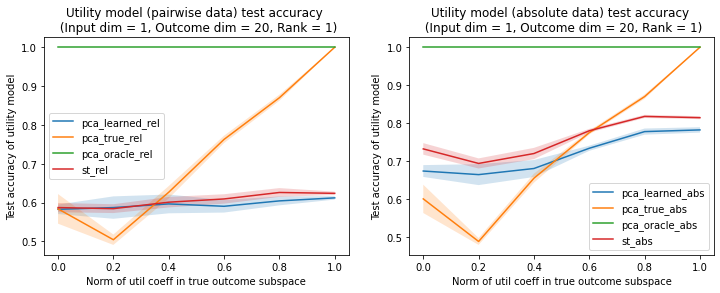

In [8]:
plot_helper(rank=1)

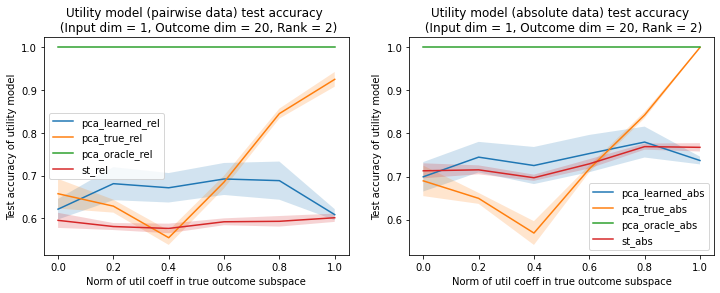

In [9]:
plot_helper(rank=2)

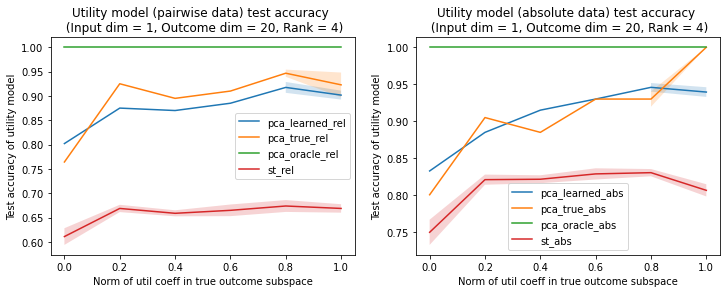

In [10]:
plot_helper(rank=4)


In [76]:
results[4]['pca']

pca_learned_rel           pca_learned_abs           pca_true_rel  \
                 mean       sem            mean       sem         mean   
alpha                                                                    
0.0          0.827857  0.028533        0.863571  0.017752     0.763571   
0.2               NaN       NaN             NaN       NaN          NaN   
0.4               NaN       NaN             NaN       NaN          NaN   
0.6               NaN       NaN             NaN       NaN          NaN   
0.8          0.945000  0.000000        0.940000  0.000000     0.920000   
1.0          0.923750  0.000818        0.955000  0.000000     0.950000   

                pca_true_abs           pca_oracle_rel      pca_oracle_abs  \
            sem         mean       sem           mean  sem           mean   
alpha                                                                       
0.0    0.046569     0.797143  0.029918            1.0  0.0            1.0   
0.2         NaN          NaN       NaN            NaN  NaN            NaN   
0.4         NaN          NaN       NaN            NaN  NaN            NaN   
0.6         NaN          NaN       NaN            NaN  NaN            NaN   
0.8    0.000000     0.920000  0.000000            1.0  0.0            1.0   
1.0    0.000000     1.000000  0.000000            1.0  0.0            1.0   

           learned_latent_dim       
       sem               mean  sem  
alpha                               
0.0    0.0                9.0  0.0  
0.2    NaN                9.0  0.0  
0.4    NaN                9.0  0.0  
0.6    NaN                9.0  0.0  
0.8    0.0                9.0  0.0  
1.0    0.0                9.0  0.0

KeyError: 'pca'

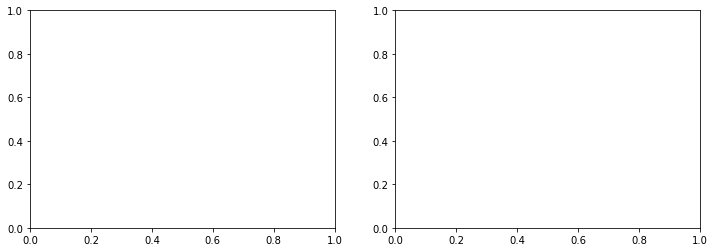

In [108]:
plot_helper(rank=6)


KeyError: 'pca'

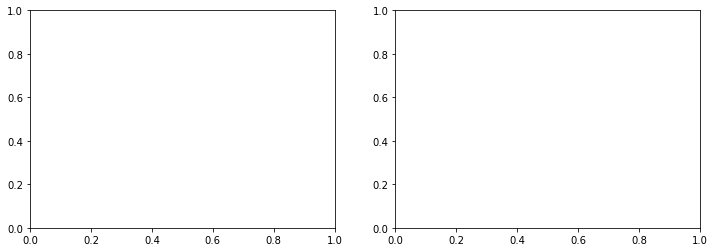

In [82]:
plot_helper(rank=8)
